In [1]:
%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image, plot_prediction
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

import pandas as pd
import numpy as np
import itertools
import os

import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


sns.set(font_scale=1.4)
sns.set(rc={'figure.figsize':(12,6)})


import pandas as pd
import numpy as np
import itertools
import os
import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


sns.set(font_scale=1.4)

/mnt/activeCell-ACDC
README.md					log
ac_acdc_env					nohup.out
acdc_large_cls_test_slim_coco_format.json	notebooks
acdc_large_cls_test_slim_coco_format.json.lock	output
al_output					pipeline_configs
coco_instances_results.json			requirements.txt
data						shell_scripts
experiments					src
instances_predictions.pth			utils
jupyter_notebooks				wandb


/mnt/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "experiments/results"

def load_experiment_results(path, experiment_dir, filename):
    
    path = os.path.join(path,experiment_dir)

    directory = os.fsencode(path)
    df_full = None

    for file in os.listdir(directory):
        fn = os.fsdecode(file)
        if fn.find(filename) != -1: 

            df = pd.read_csv(os.path.join(path, fn))

            if len(df) == 1:
                continue

            #print(fn)
            if df_full is None:
                df_full = df
            else:
                df_full=  pd.concat([df_full, df])
        else:
            print("file ignored:", fn)
    
    return df_full

In [3]:

def get_ap_df(model_train_size):
    with open(f"experiments/results/maps_{model_train_size}.txt","r") as file:
        js_obj = json.load(file)

    records = [{"image_id":key, "segm_ap": js_obj[key]["segm"]["AP"] }for key in js_obj.keys()]
    df = pd.DataFrame.from_records(records)
    df["model_train_size"] = model_train_size
    
    return df

def latex_pd(df):
    df = df.round(3)
    return df.to_latex(index=False)

In [81]:

def get_experiment(path, experiment_dir, filename,  agg_cols, filter_cols=None):
    
    
    agg_cols_wio_train = list(set(agg_cols) - set(["model_train_size"]))
    
    tta_gs_df = load_experiment_results(path, experiment_dir, filename)
    print(tta_gs_df.head())
    if filter_cols:
        for col in filter_cols.keys():
            tta_gs_df = tta_gs_df[tta_gs_df[col] == filter_cols[col]]
    
    tta_gs_df = tta_gs_df[tta_gs_df["model_train_size"] != 45]
    #tta_gs_df = tta_gs_df[tta_gs_df["model_train_size"] != 15]
    
    if len(tta_gs_df) == 0:
        print("error in import")
        return
    
    df_ap = None
    for model_train_size in [15, 45, 240, 3000, 5800]:
        df = get_ap_df(model_train_size)
        if df_ap is None:
            df_ap = df
        else:
            df_ap =  pd.concat([df_ap, df])
    
    
    tta_gs_df =  pd.merge(
        tta_gs_df,
        df_ap,
        how="inner",
        on=["model_train_size","image_id"])


    tta_gs_df["certainty"] = 1 - tta_gs_df["agg_uncertainty"]
    tta_gs_df["ap_scale"] = tta_gs_df["segm_ap"]/100

    tta_gs_df["neg_conf_gap"] = (tta_gs_df["ap_scale"] - tta_gs_df["certainty"]) * (tta_gs_df["ap_scale"] - tta_gs_df["certainty"] < 0)


    


    records = []
    
    tta_gs_df["is_quant_i"] = 0

    agg_cols_values = [tta_gs_df[col_name].unique() for col_name in agg_cols]
    for element in itertools.product(*agg_cols_values):
        tmp_df = tta_gs_df.copy()
        for col in agg_cols:
            tmp_df = tmp_df[tmp_df[col] == element[agg_cols.index(col)]]
        
        record = {col:tmp_df[col].values[0] for col in agg_cols}

        record["corr"] = tmp_df[["certainty", "ap_scale"]].corr()["certainty"]["ap_scale"]
        record["neg_conf_gap"] = tmp_df["neg_conf_gap"].sum()
             
        quant = 0.25
        
        intersection = set(tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(quant)]["image_id"].values).intersection(set(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(quant)]["image_id"].values))
        union = len(set(tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(quant)]["image_id"].values).union(set(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(quant)]["image_id"].values)))
        record["quant_iou"] = len(intersection)/union
        
        for id_ in list(intersection):
            tta_gs_df.loc[(tta_gs_df["image_id"] == id_) & (tta_gs_df["model_train_size"] == tmp_df["model_train_size"].values[0])  & (tta_gs_df["max_noise"] == tmp_df["max_noise"].values[0]) & (tta_gs_df["num_mc_samples"] == tmp_df["num_mc_samples"].values[0]), "is_quant_i"] = 1

        
        
        #(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(.5)]["ap_scale"].mean() - tmp_df["ap_scale"].mean()) / (tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(.5)]["ap_scale"].mean()- tmp_df["ap_scale"].mean())
        
        #record["u_worst_map"] = (tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(.5)]["certainty"].mean() - tmp_df["certainty"].mean()) / (tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(.5)]["certainty"].mean()- tmp_df["certainty"].mean())
        


        #print(record)    
        records.append(record)
    
    
    
        

    df = pd.DataFrame.from_records(records)

    print(df.sort_values(by=["corr"], ascending=False), "\n")
    print(df.sort_values(by=["quant_iou"], ascending=False))
    
    
    print(latex_pd(df[df.groupby("model_train_size")['corr'].transform(max) == df['corr']].sort_values("model_train_size")[["model_train_size"] + agg_cols_wio_train + ["corr", "quant_iou"]]), "\n")
    
    print(latex_pd(df[df["model_train_size"] == 5800].groupby(agg_cols_wio_train).mean().reset_index().sort_values(by=["corr"], ascending=False)[agg_cols_wio_train + ["corr", "quant_iou"]]), "\n")

    for col in agg_cols:
        print(latex_pd(df.groupby(by=[col]).mean().reset_index().sort_values(by=["corr"], ascending=False)[[col, "corr", "quant_iou"]]), "\n")

    tmp_df = df
    tmp_df = tmp_df[tmp_df["num_mc_samples"] == 20]
    print(latex_pd(tmp_df.groupby(agg_cols_wio_train).mean().reset_index().sort_values(by=["corr"], ascending=False)[agg_cols_wio_train + ["corr", "quant_iou"]]), "\n")
    
    agg_cols_values = [tta_gs_df[col_name].unique() for col_name in agg_cols_wio_train if col_name != "model_train_size"]
    print(agg_cols_values)

    for element in itertools.product(*agg_cols_values):
        tmp_df = tta_gs_df.copy()
        for col in agg_cols_wio_train:
            tmp_df = tmp_df[tmp_df[col] == element[agg_cols_wio_train.index(col)]]


        tmp_df["Certainty"] = tmp_df["certainty"]
        tmp_df["Normalized mAP"] = tmp_df["ap_scale"]
        tmp_df["Size of training data set"] = tmp_df["model_train_size"]
        
        if True or tmp_df["max_noise"].values[0] in [0] and tmp_df["num_mc_samples"].values[0] == 20:
            print({col:tmp_df[col].values[0] for col in agg_cols_wio_train})
            myplot = sns.lmplot(data=tmp_df, x="Certainty", y="Normalized mAP", hue="is_quant_i", ci=None, col='Size of training data set', line_kws={'color': 'orange'}, col_wrap=2, fit_reg=False, legend=False)
            plt.show()
        
        


file ignored: .ipynb_checkpoints
file ignored: old
   Unnamed: 0  num_mc_samples  max_noise  model_train_size  \
0           0              10      0.001                15   
1           1              10      0.001                15   
2           2              10      0.001                15   
3           3              10      0.001                15   
4           4              10      0.001                15   

                                    image_id  run_id  agg_uncertainty  
0               acdc_data3_20210722_pos_5_36       0         0.550729  
1            acdc_data3_Yagya_SCD_WT_pos_5_0       0         0.560405  
2              acdc_data3_20210722_pos_2_144       0         0.512413  
3              acdc_data3_20211029_pos_1_165       0         0.514512  
4  acdc_data2_kurt_306-3_0_20201028_pos_1_93       0         0.586688  
    num_mc_samples  max_noise  model_train_size      corr  neg_conf_gap  \
11              10      0.010               240  0.430582     -1.4961

/tmp/ipykernel_853528/1243899865.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(index=False)
/tmp/ipykernel_853528/1243899865.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(index=False)
/tmp/ipykernel_853528/1243899865.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It 

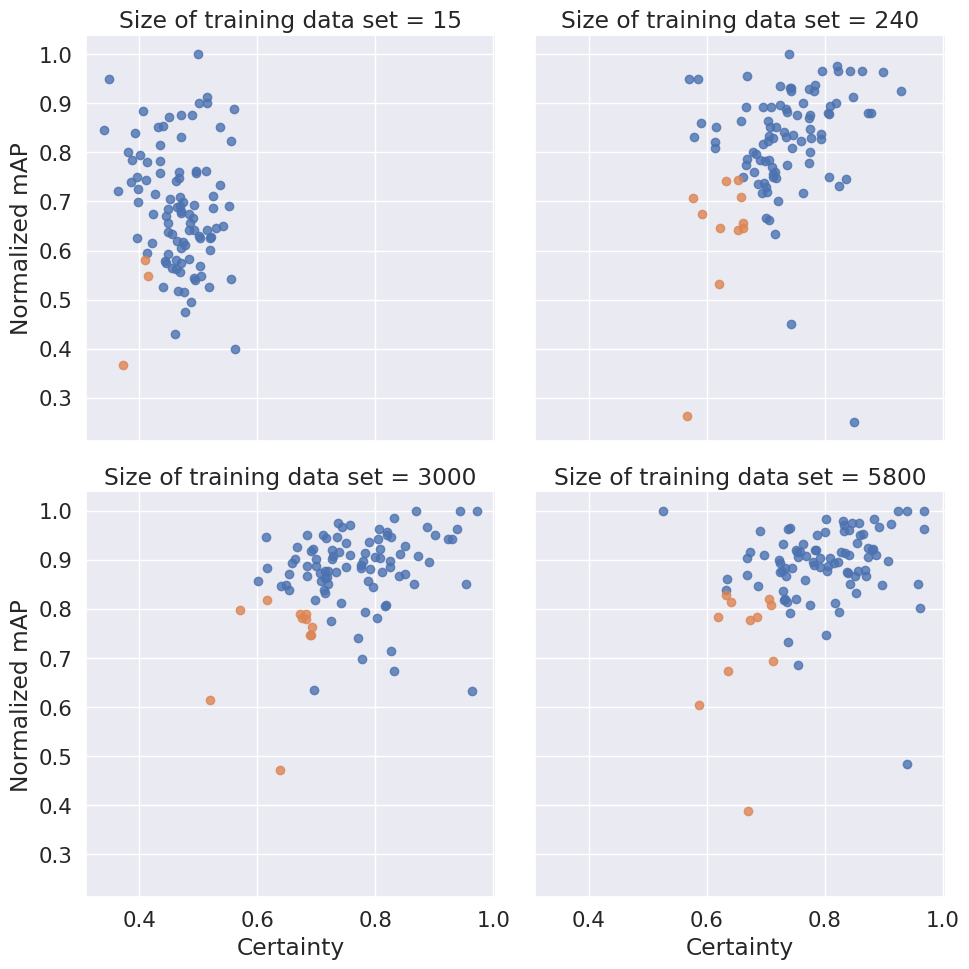

{'max_noise': 0.001, 'num_mc_samples': 40}


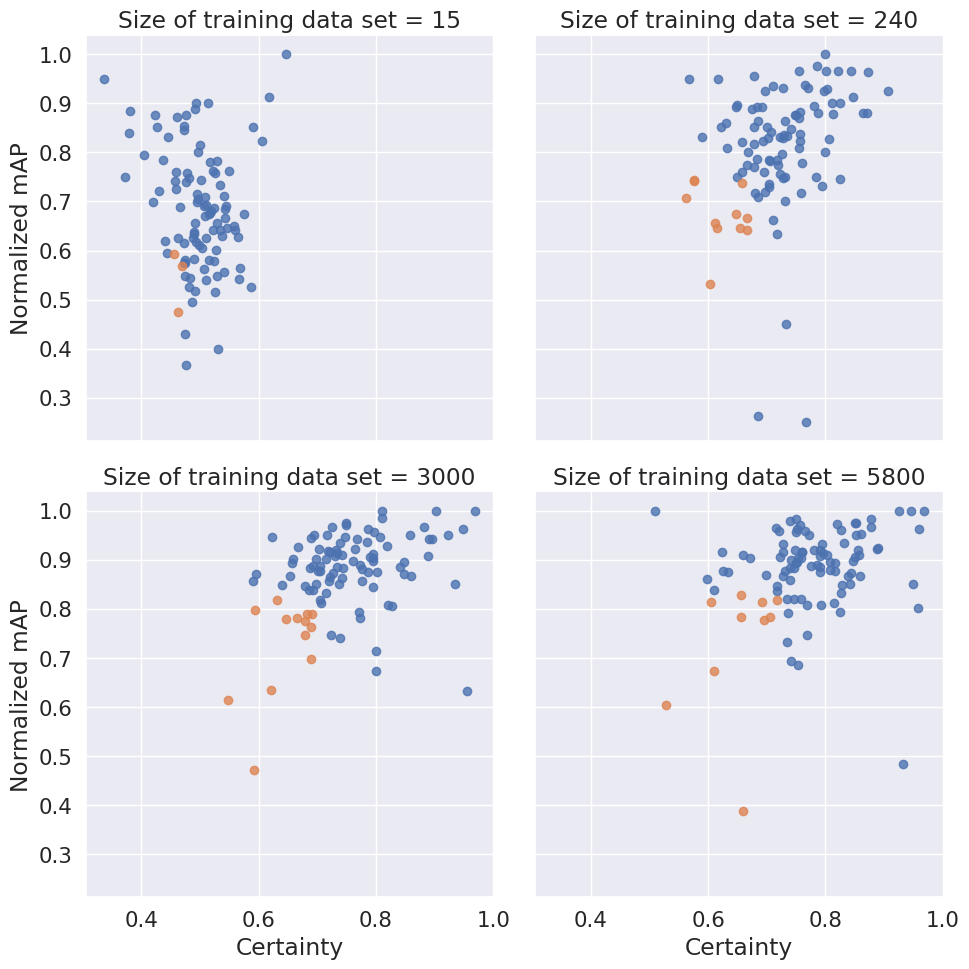

{'max_noise': 0.001, 'num_mc_samples': 5}


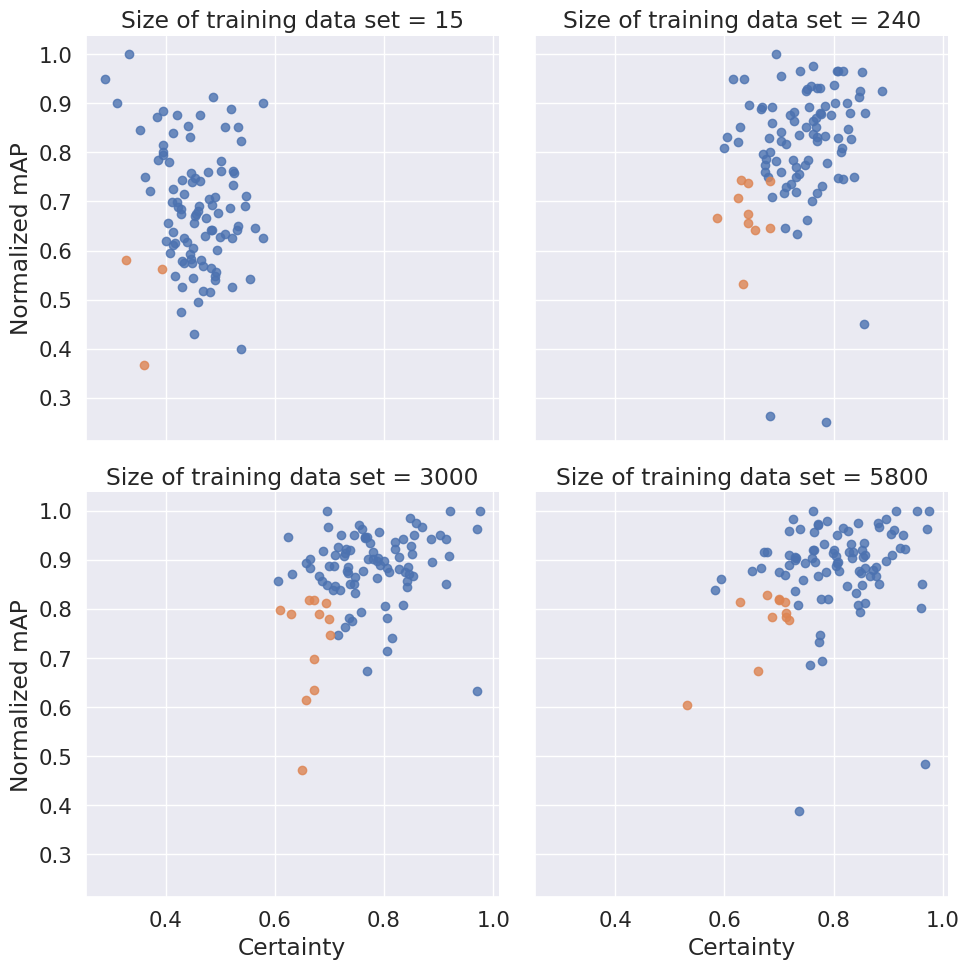

{'max_noise': 0.001, 'num_mc_samples': 30}


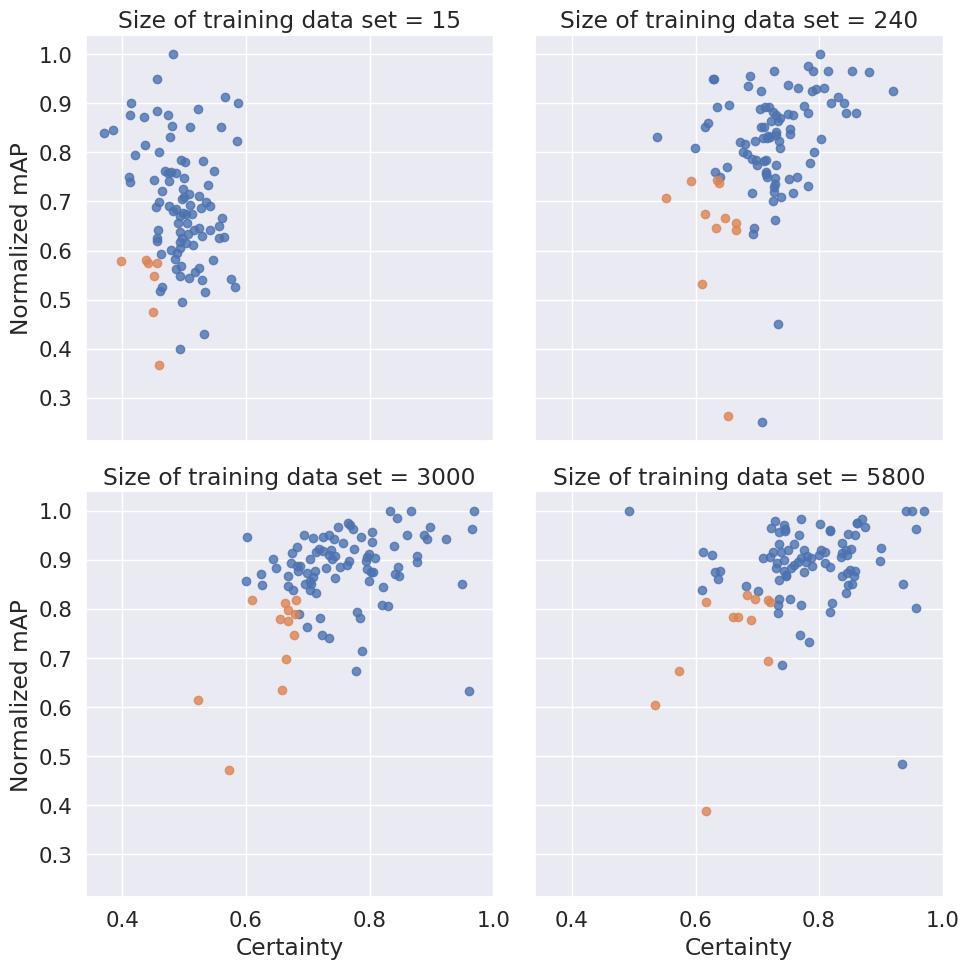

{'max_noise': 0.001, 'num_mc_samples': 20}


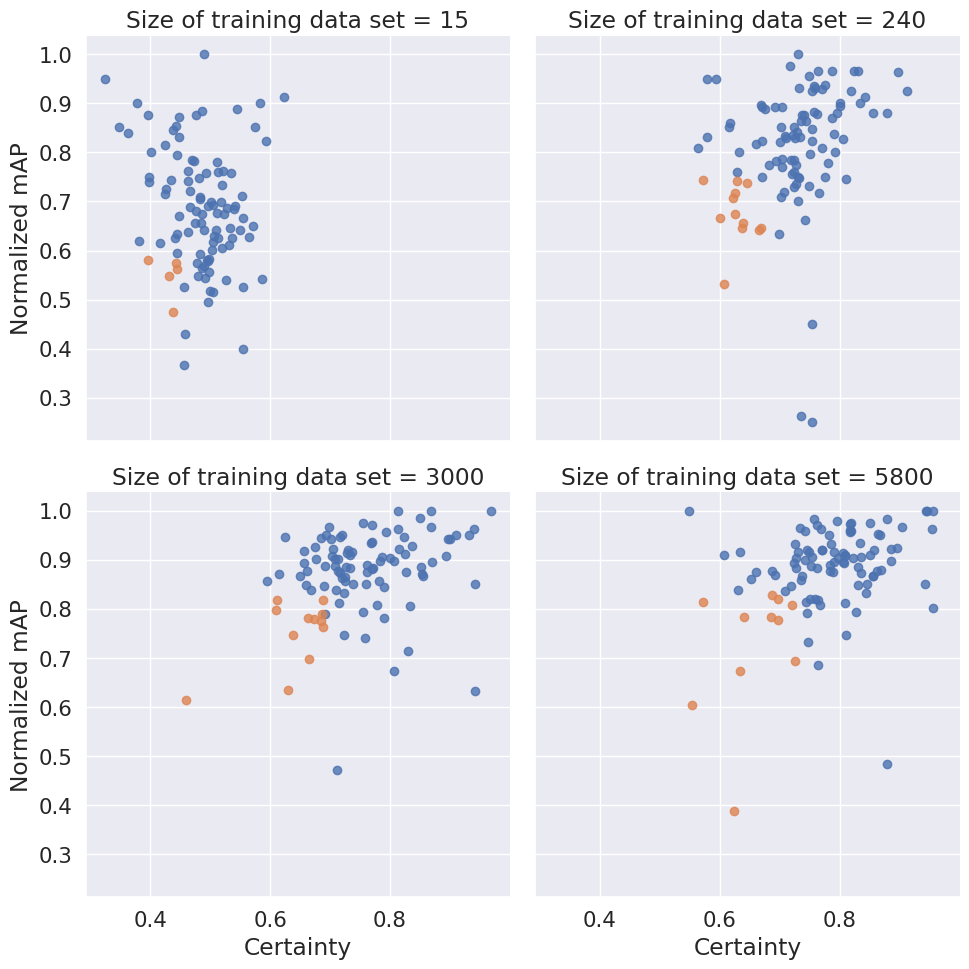

{'max_noise': 0.1, 'num_mc_samples': 10}


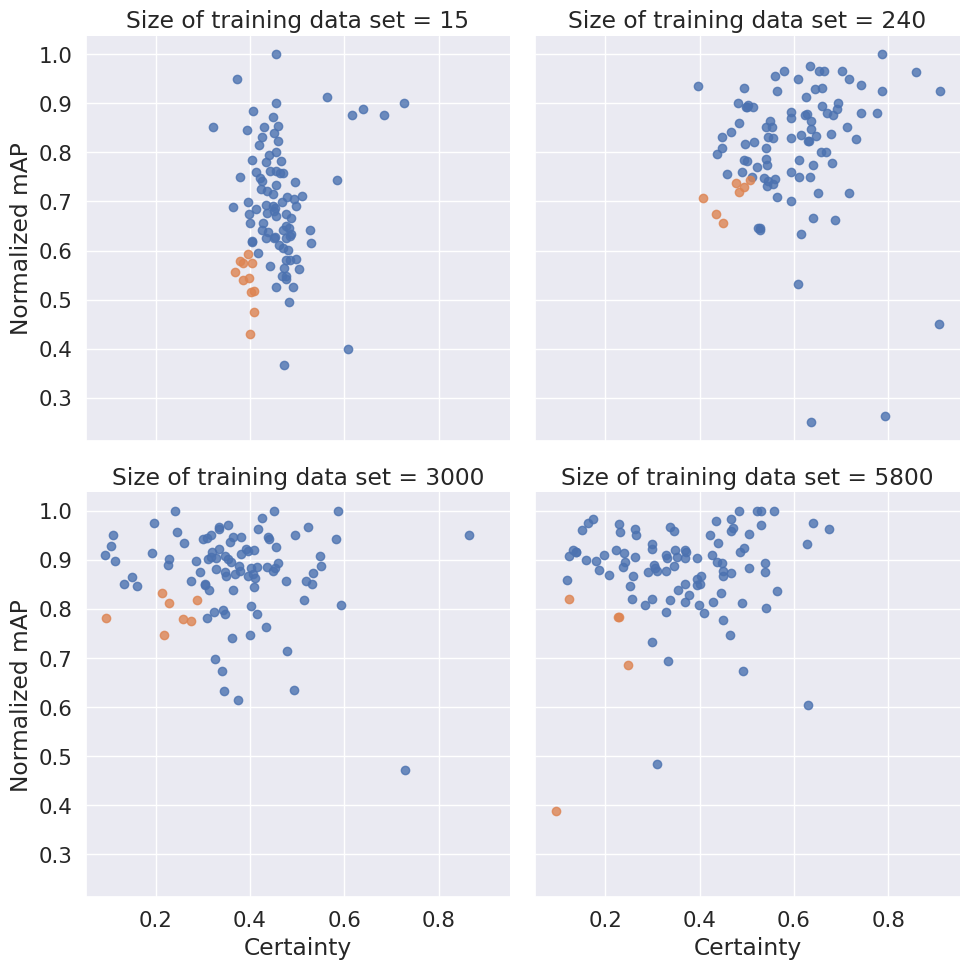

{'max_noise': 0.1, 'num_mc_samples': 40}


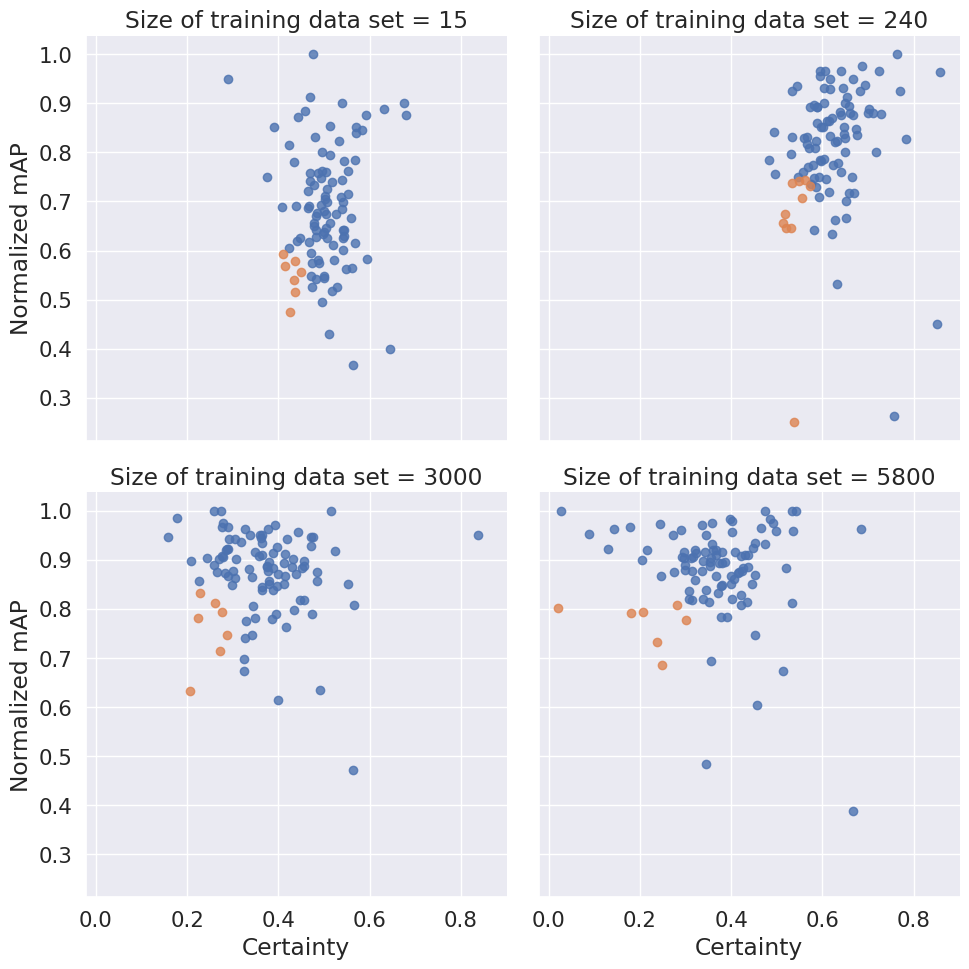

{'max_noise': 0.1, 'num_mc_samples': 5}


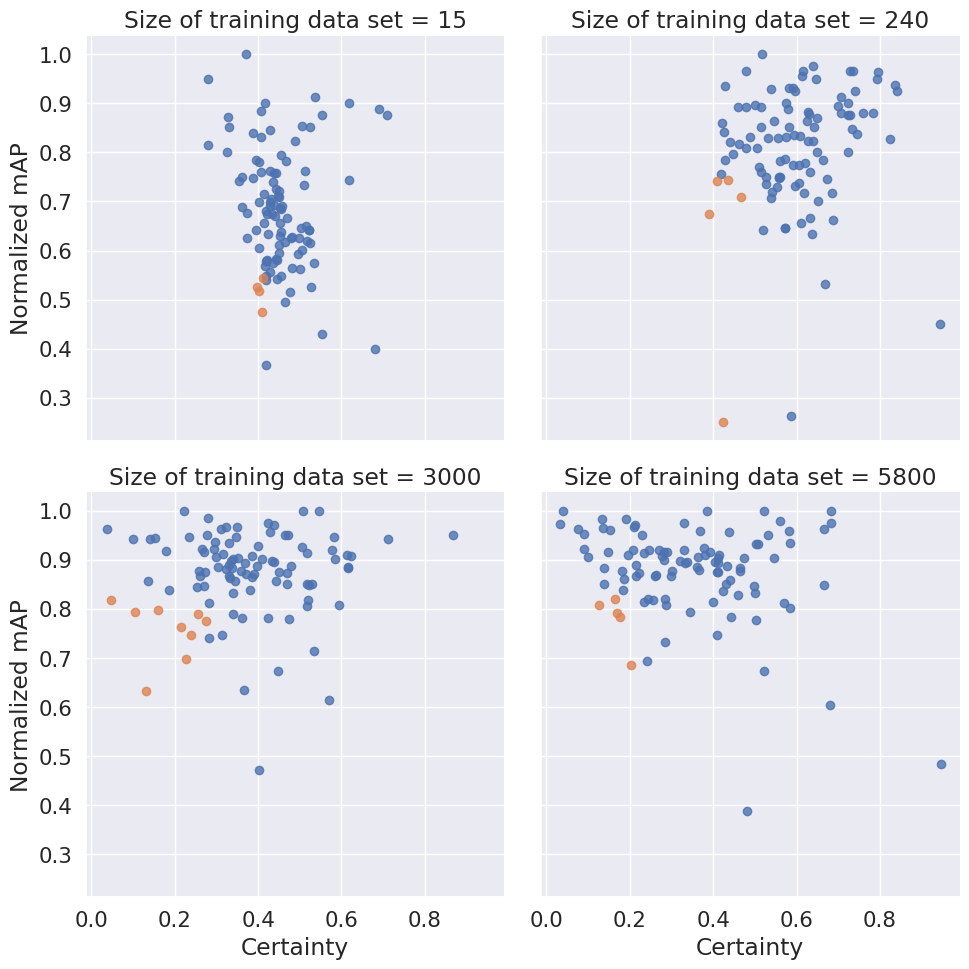

{'max_noise': 0.1, 'num_mc_samples': 30}


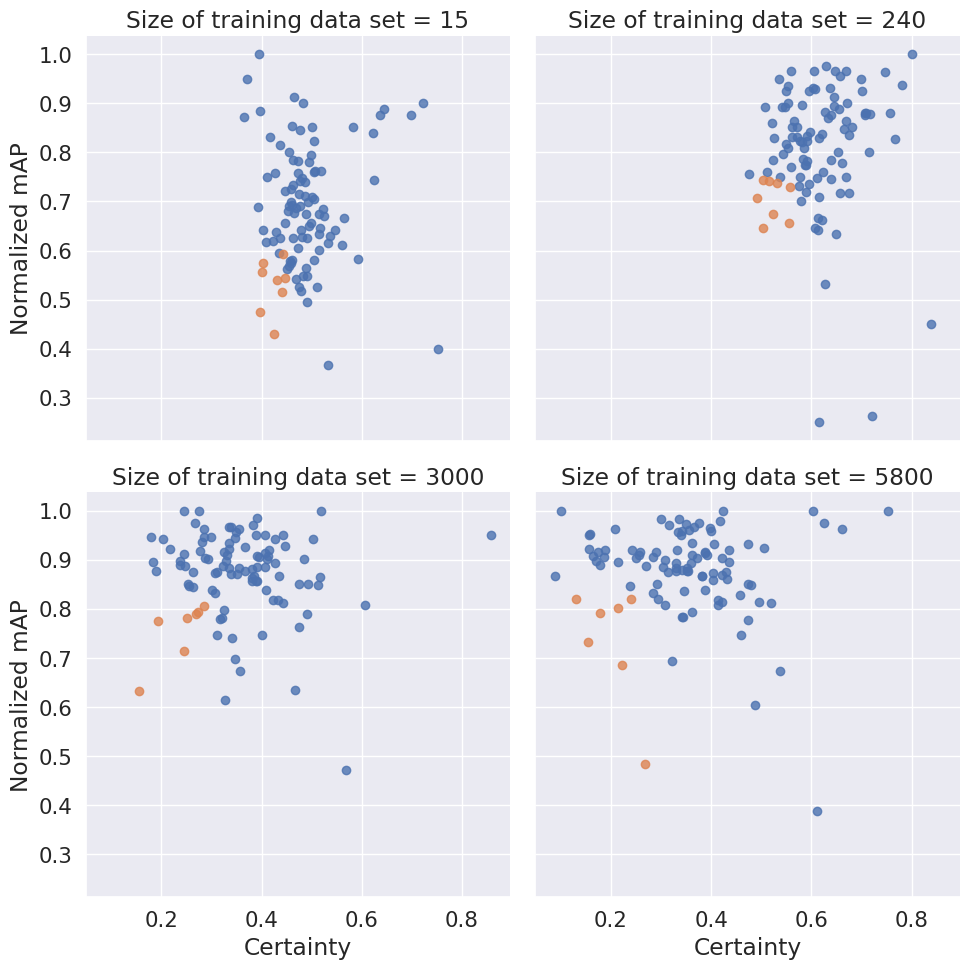

{'max_noise': 0.1, 'num_mc_samples': 20}


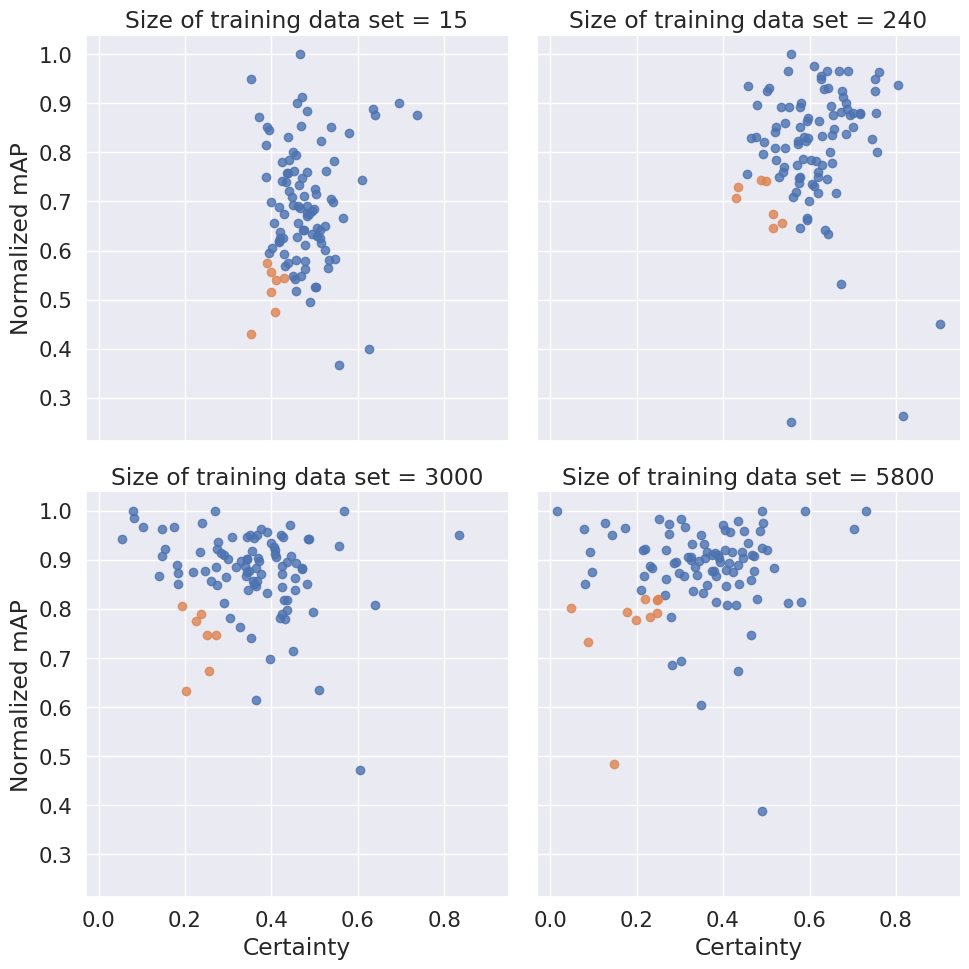

{'max_noise': 0.01, 'num_mc_samples': 10}


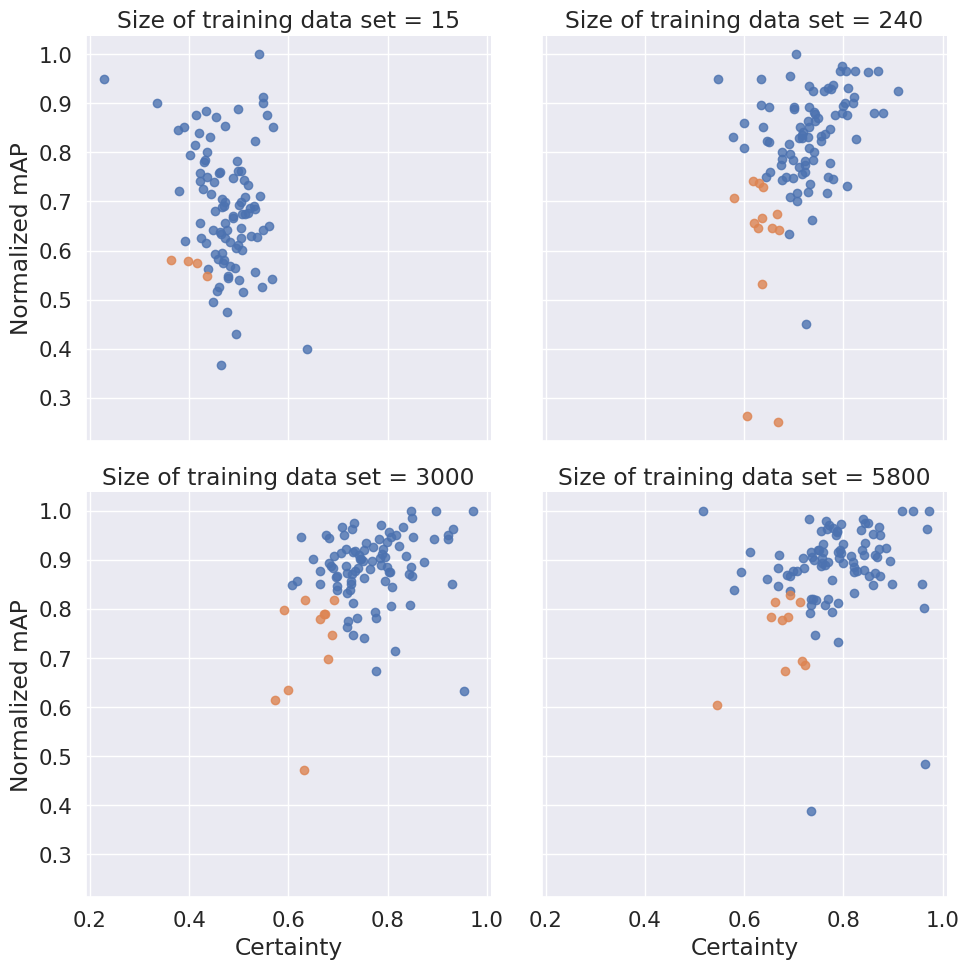

{'max_noise': 0.01, 'num_mc_samples': 40}


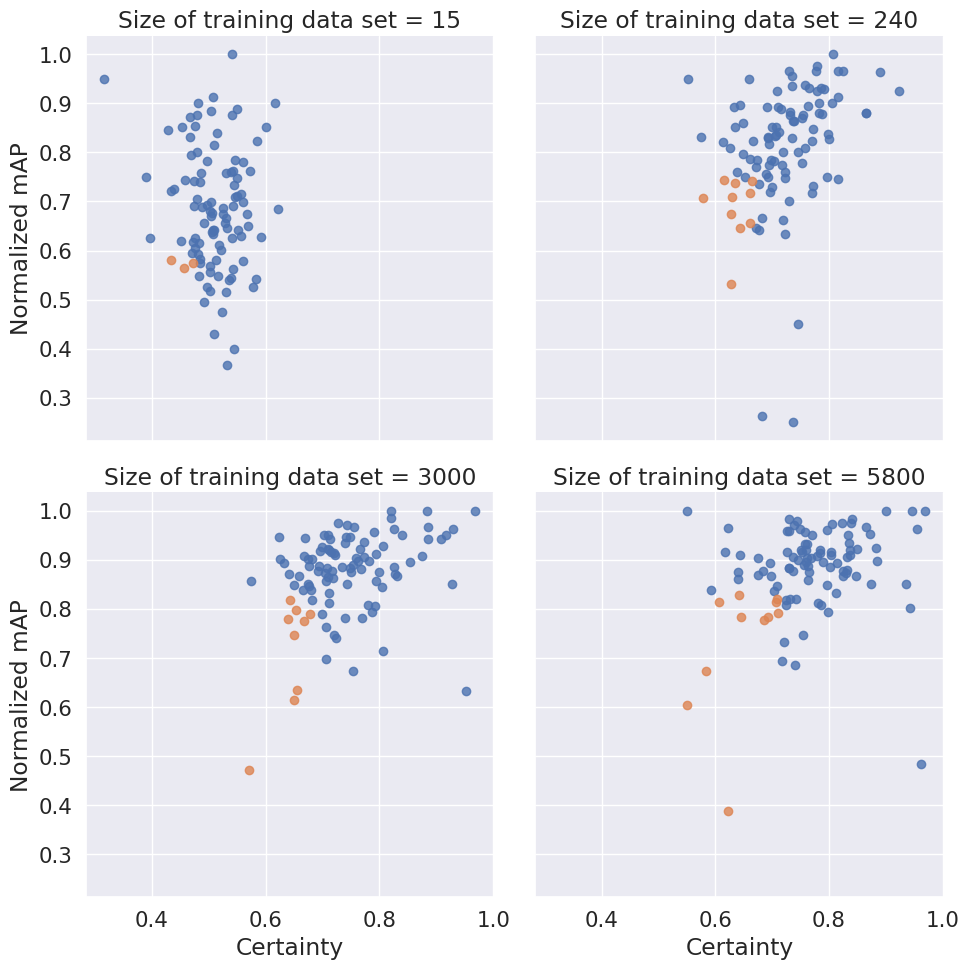

{'max_noise': 0.01, 'num_mc_samples': 5}


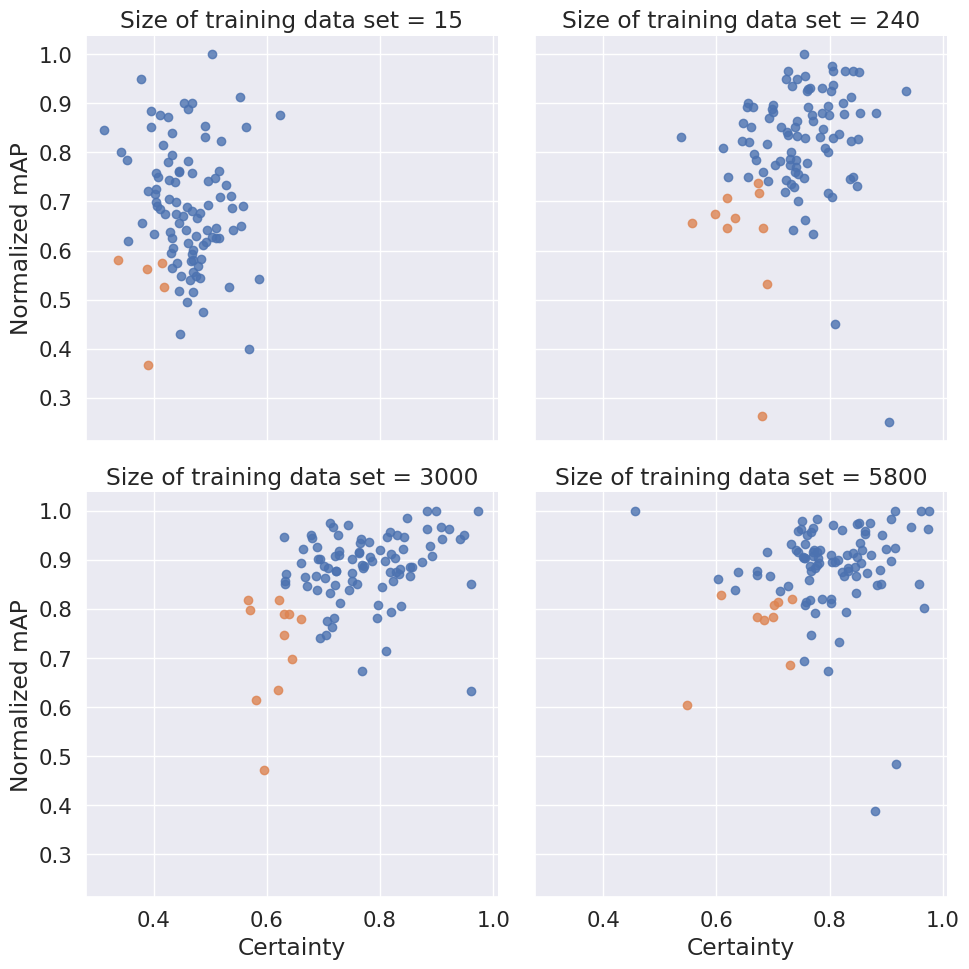

{'max_noise': 0.01, 'num_mc_samples': 30}


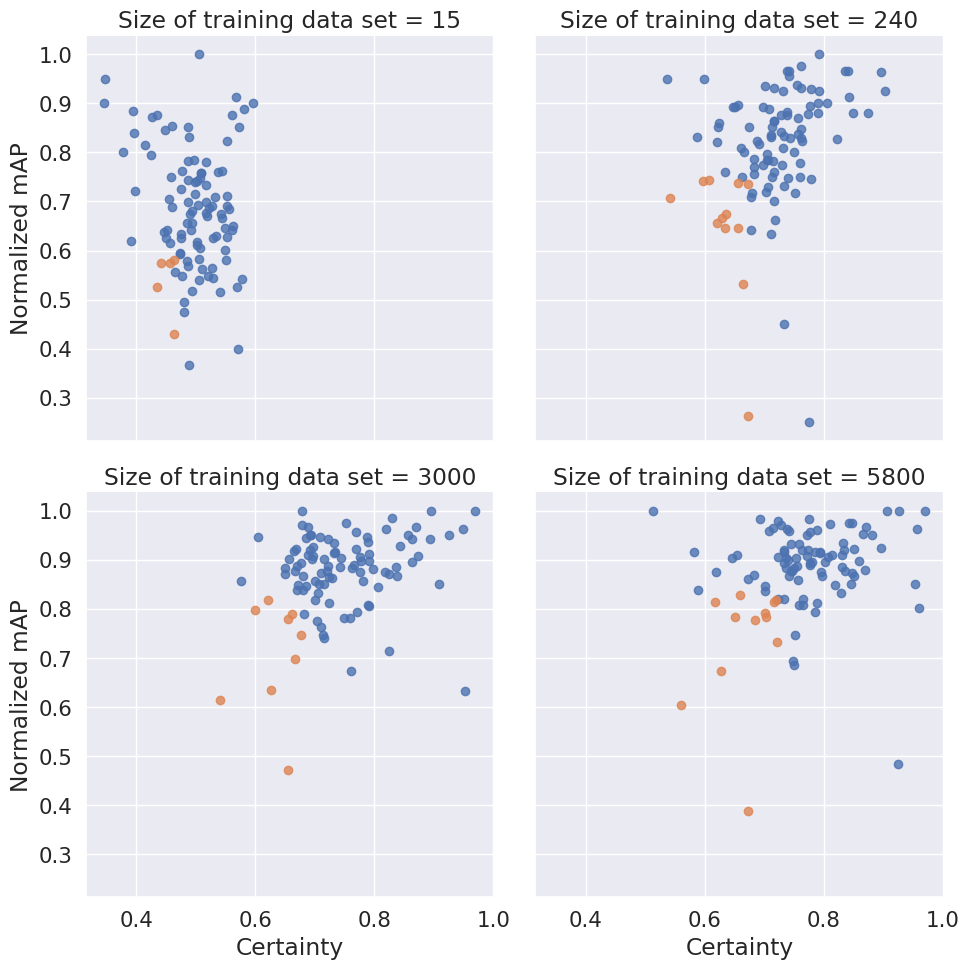

{'max_noise': 0.01, 'num_mc_samples': 20}


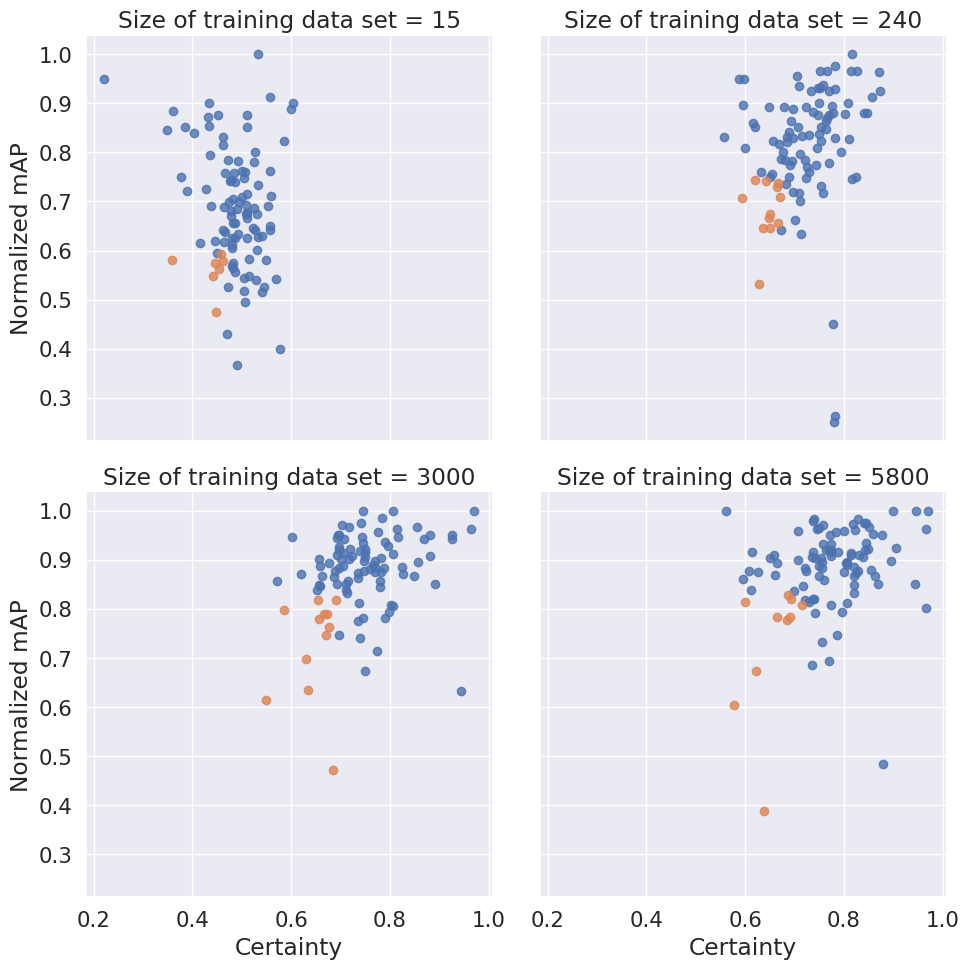

{'max_noise': 0.0, 'num_mc_samples': 10}


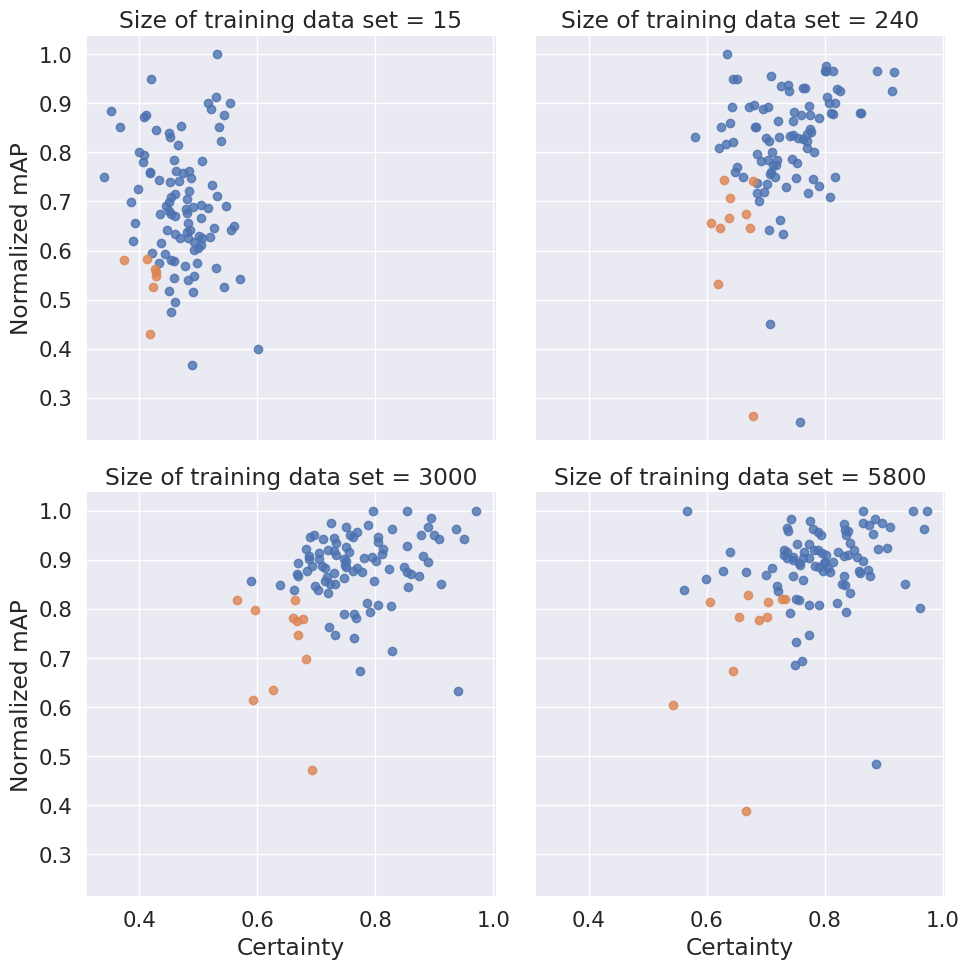

{'max_noise': 0.0, 'num_mc_samples': 40}


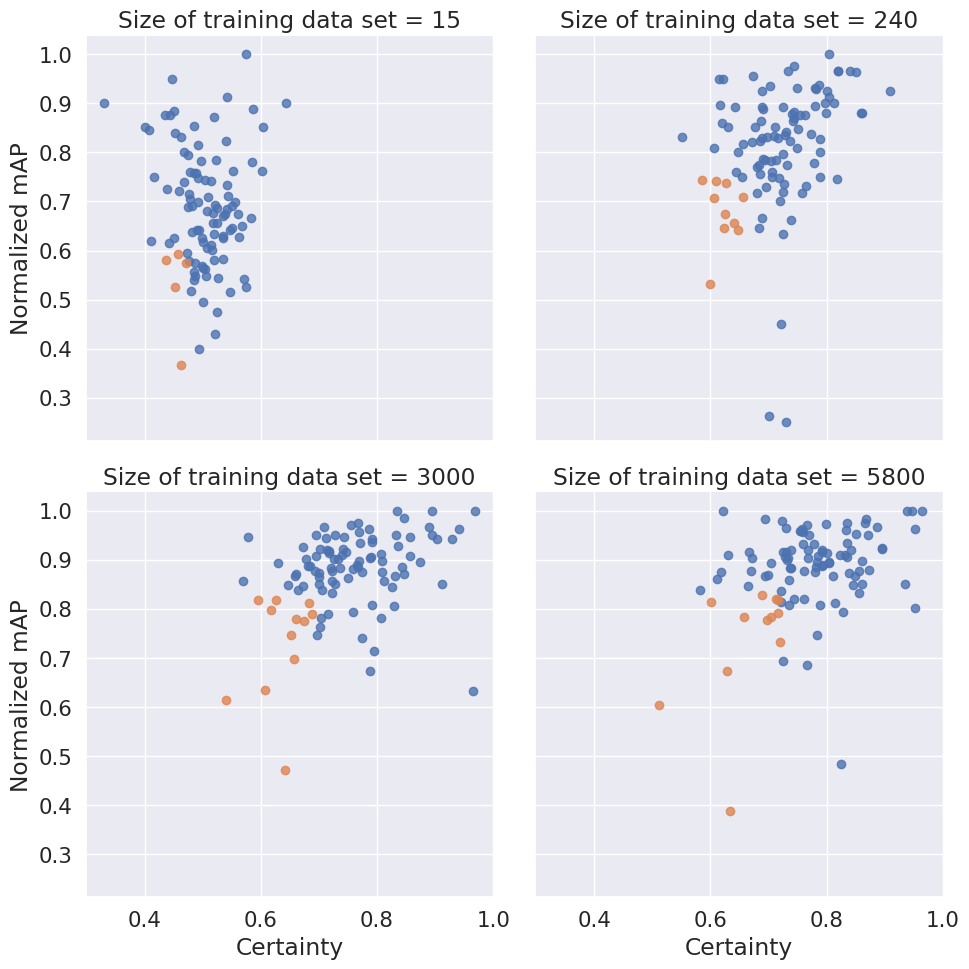

{'max_noise': 0.0, 'num_mc_samples': 5}


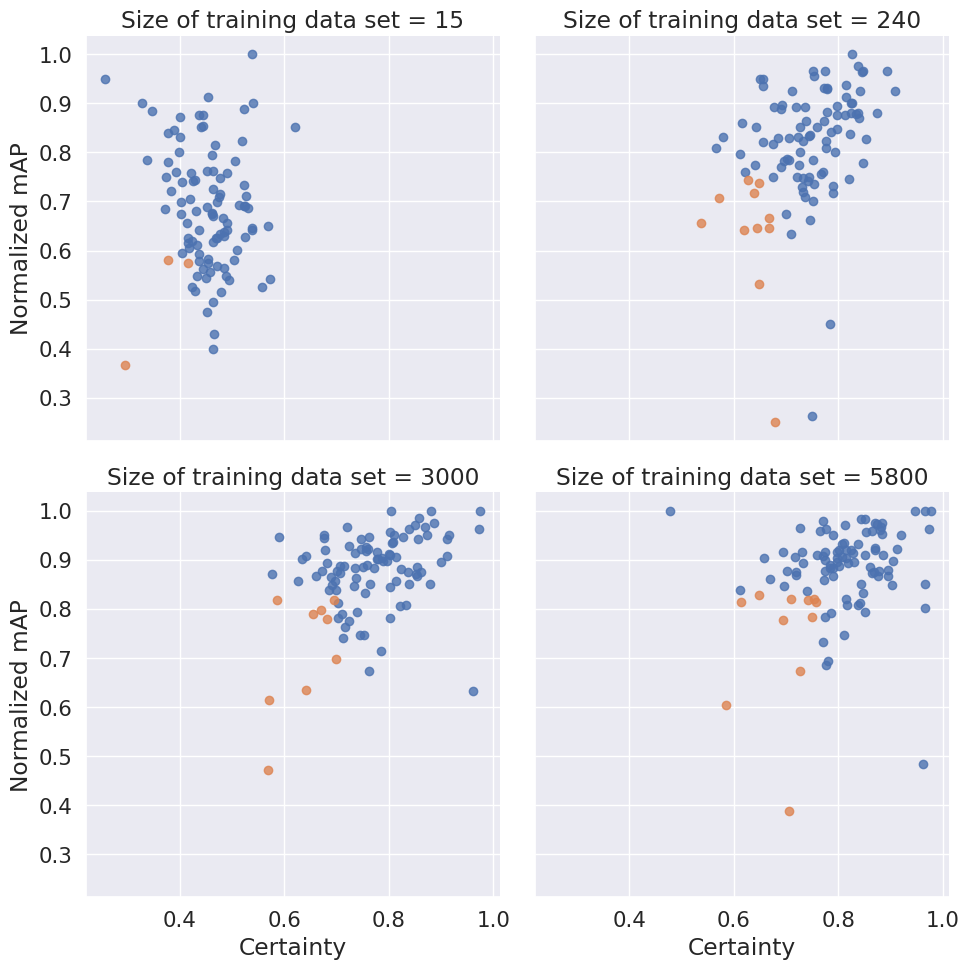

{'max_noise': 0.0, 'num_mc_samples': 30}


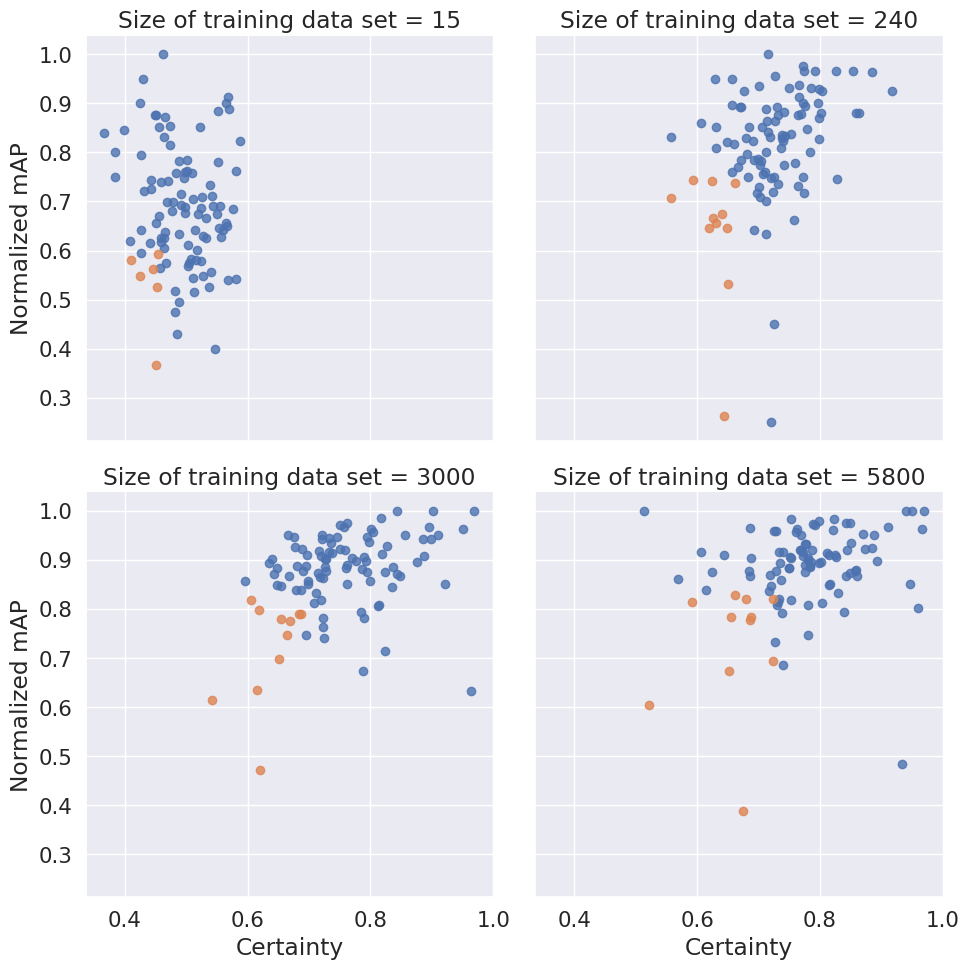

{'max_noise': 0.0, 'num_mc_samples': 20}


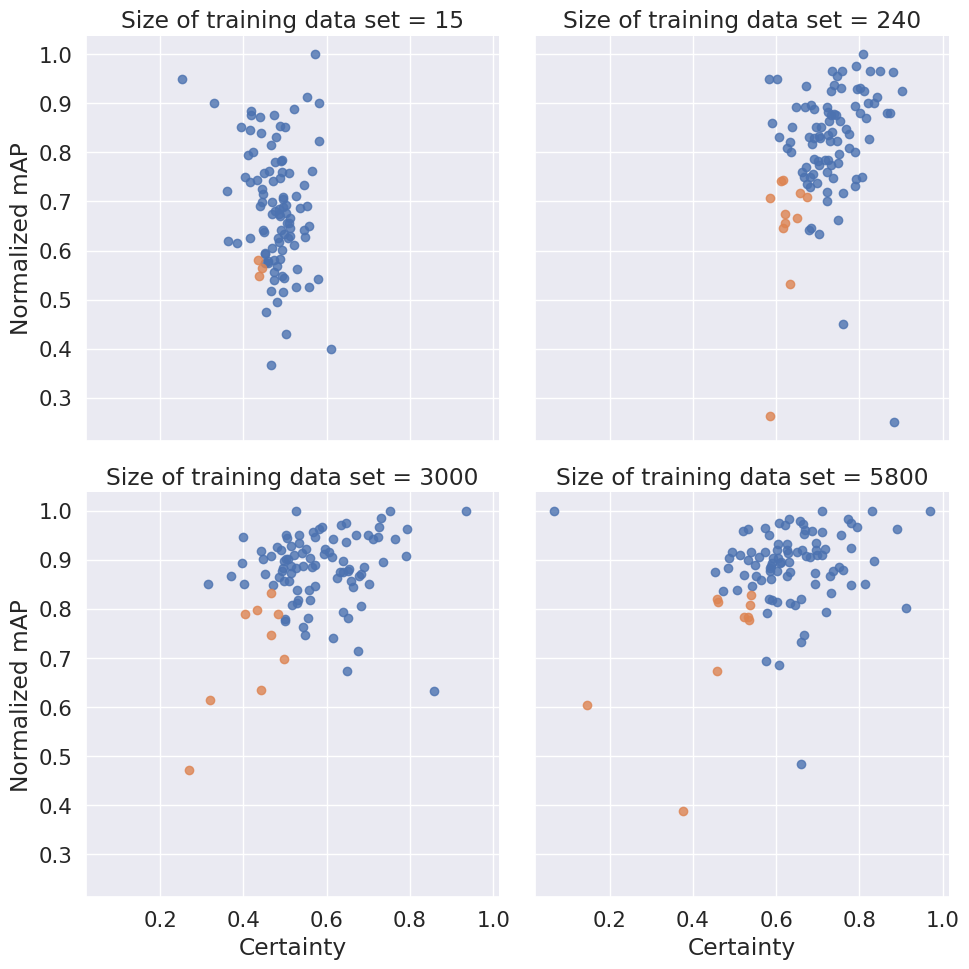

{'max_noise': 0.05, 'num_mc_samples': 10}


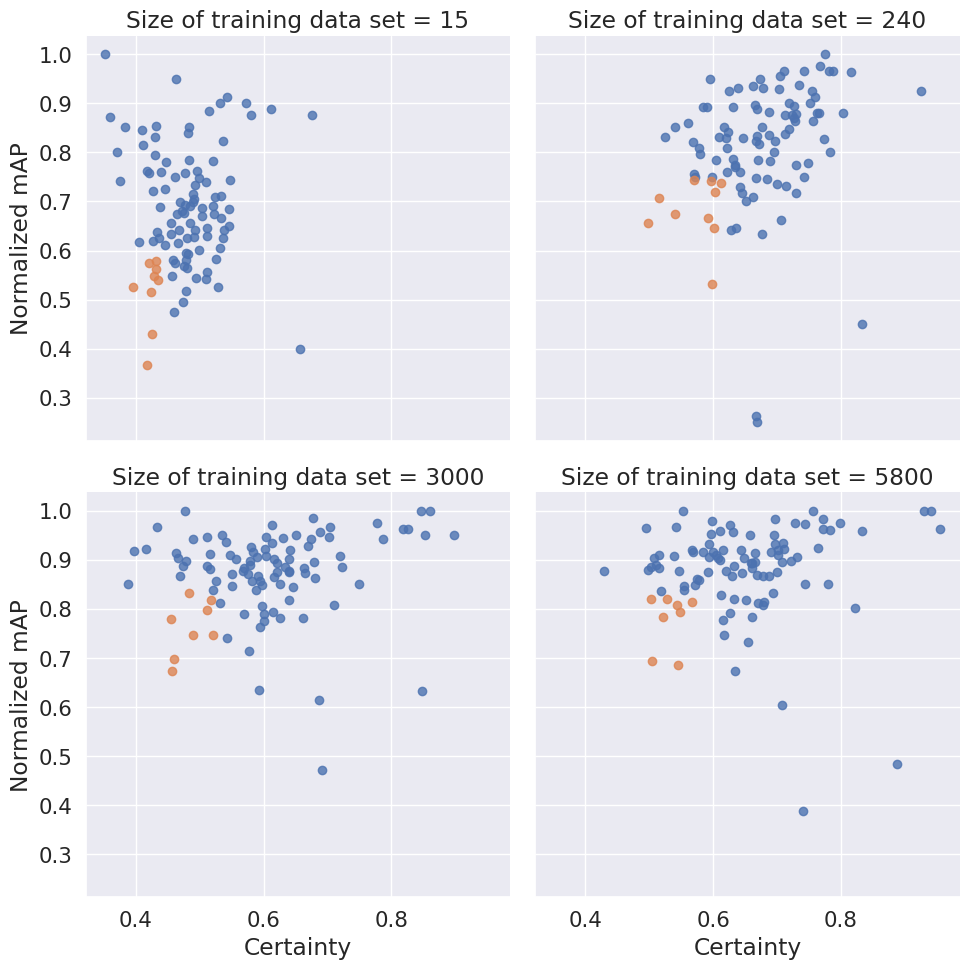

{'max_noise': 0.05, 'num_mc_samples': 40}


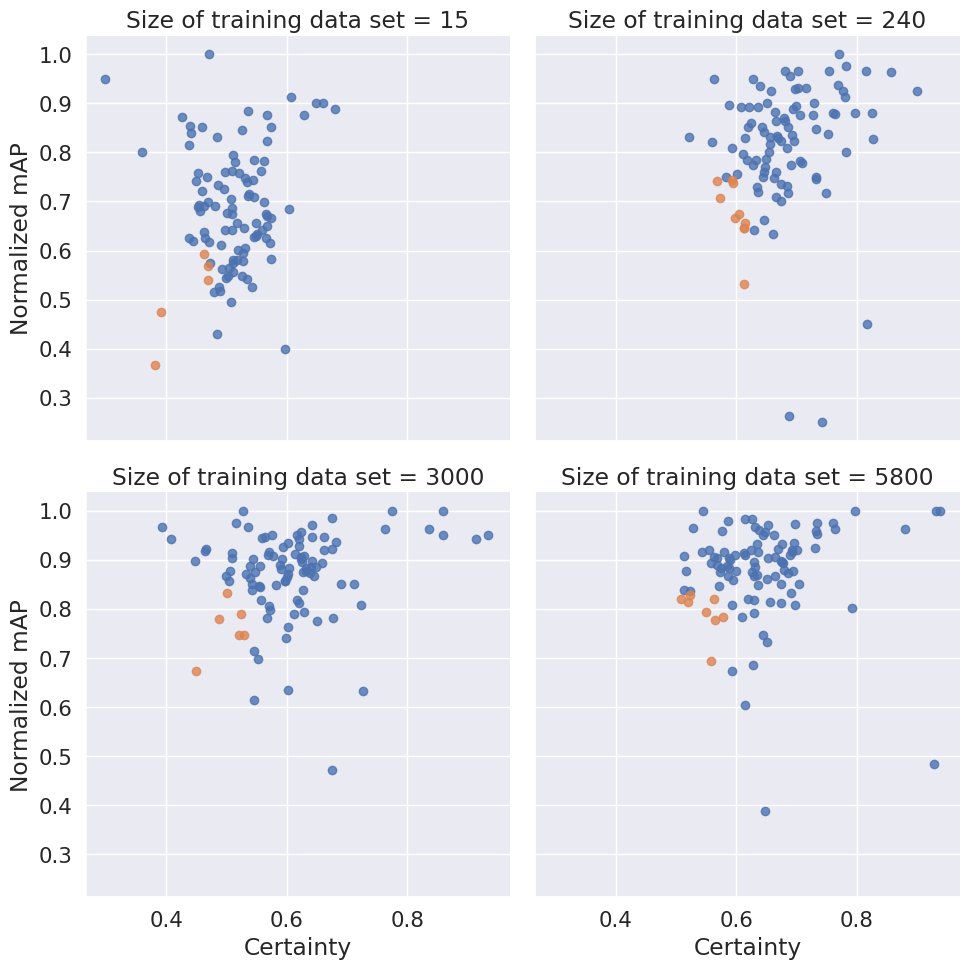

{'max_noise': 0.05, 'num_mc_samples': 5}


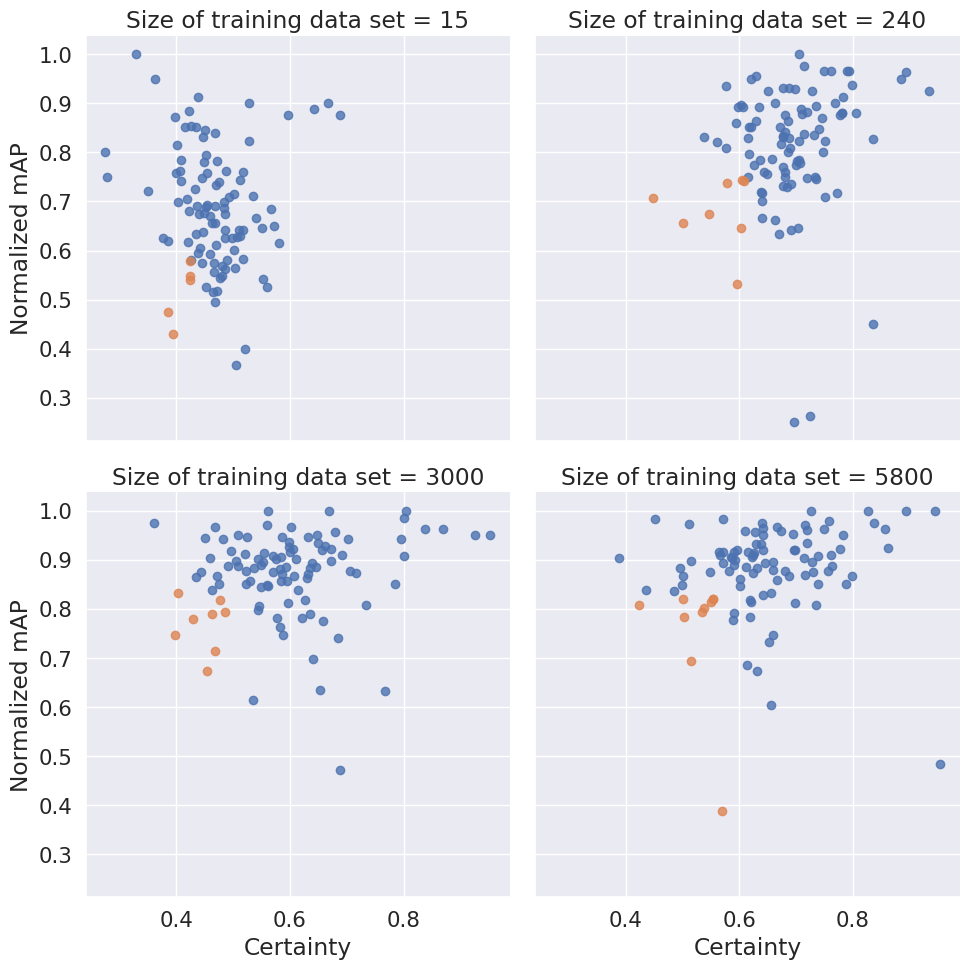

{'max_noise': 0.05, 'num_mc_samples': 30}


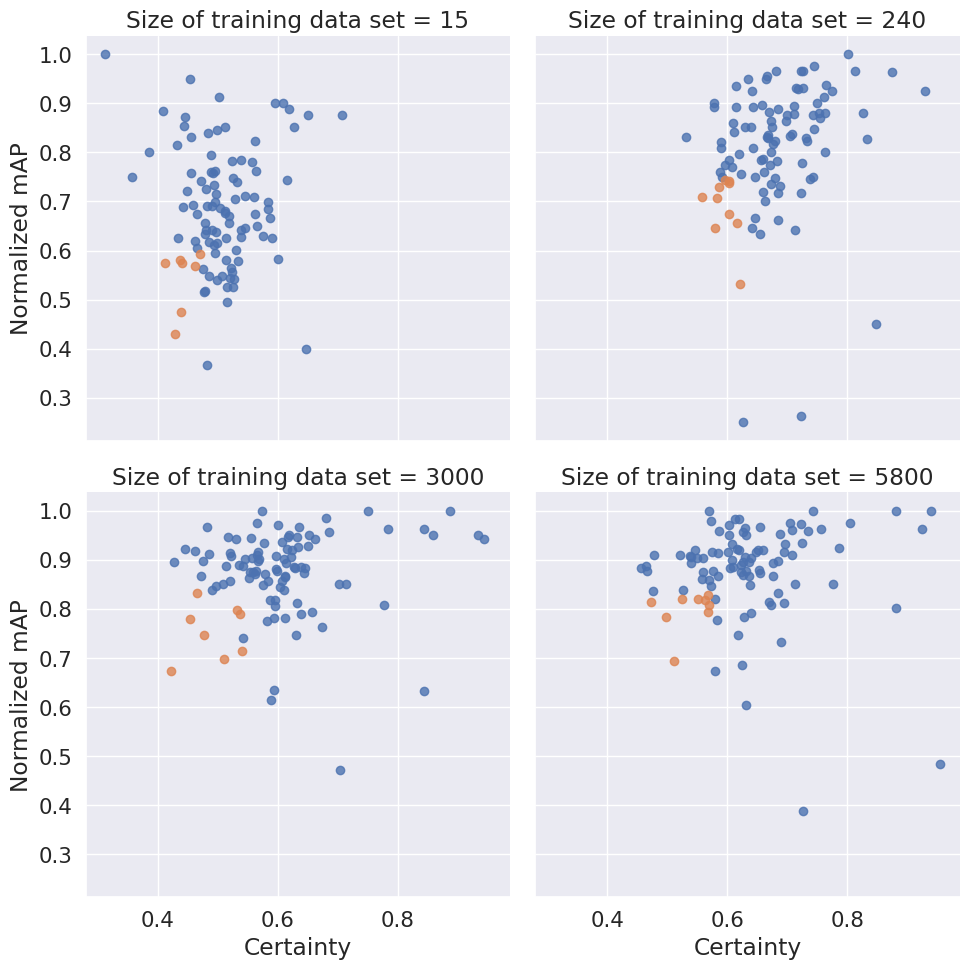

{'max_noise': 0.05, 'num_mc_samples': 20}


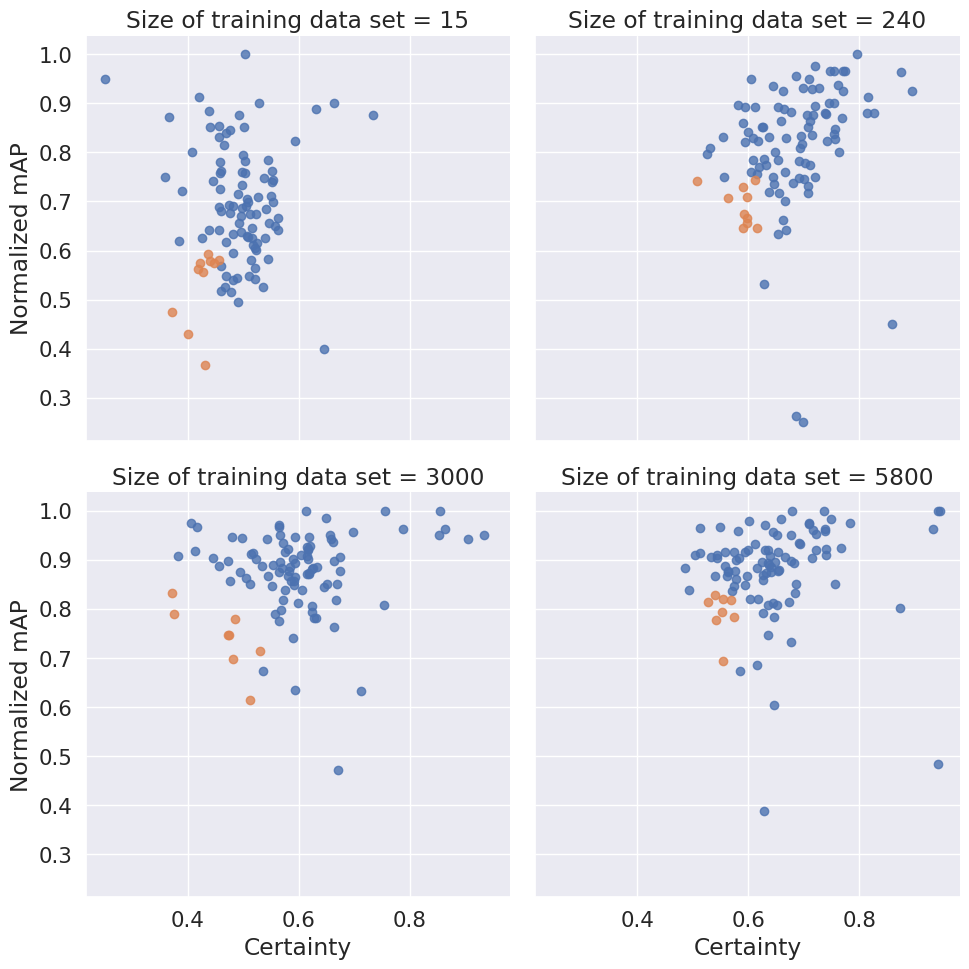

In [82]:

experiment_dir="tta_gridsearch"
filename = "tta_gridseach"
agg_cols = ["num_mc_samples","max_noise", "model_train_size"]

get_experiment(path, experiment_dir, filename,  agg_cols)

In [84]:
df_full = load_experiment_results(path, experiment_dir, filename)
df_full["certainty"] = 1 - df_full["agg_uncertainty"]
df_ap = None
for model_train_size in [15, 45, 240, 3000, 5800]:
    df = get_ap_df(model_train_size)
    if df_ap is None:
        df_ap = df
    else:
        df_ap =  pd.concat([df_ap, df])


df_full =  pd.merge(
    df_full,
    df_ap,
    how="inner",
    on=["model_train_size","image_id"])



df = df_full[(df_full["num_mc_samples"] == 20) & (df_full["model_train_size"] == 5800) & (df_full["max_noise"] == 0)]
df.sort_values("segm_ap").head()


file ignored: .ipynb_checkpoints
file ignored: old


,Unnamed: 0,num_mc_samples,max_noise,model_train_size,image_id,run_id,agg_uncertainty,certainty,segm_ap
6484,59,20,0.0,5800,acdc_data3_20210722_pos_18_39,0,0.622956,0.377044,38.778878
7134,85,20,0.0,5800,acdc_data3_20210722_pos_18_30,0,0.340465,0.659535,48.333333
5509,20,20,0.0,5800,acdc_data2_F016_pos_3_51,0,0.853627,0.146373,60.374037
6609,64,20,0.0,5800,acdc_data3_20210722_pos_2_30,0,0.542681,0.457319,67.376238
6784,71,20,0.0,5800,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0,0.394167,0.605833,68.512651


In [67]:
def val2dicts(val):

    preds = []
    for v in val:
        pred_masks = v["pred_masks"].detach().cpu().numpy()
        pred_classes = v["pred_classes"].detach().cpu().numpy()

        preds.append({
            "pred_masks": pred_masks,
            "pred_classes": pred_classes,
        })

    return preds

def get_uncertainties(im_json, model, query_strategy):

    im = query_strategy.load_image(im_json)
    instance_list = query_strategy.get_samples(model, im, cfg.AL.NUM_MC_SAMPLES)
    combinded_instances = query_strategy.get_combinded_instances(instance_list)


    height, width = im.shape[:2]
    agg_uncertainty = query_strategy.get_uncertainty(combinded_instances, cfg.AL.NUM_MC_SAMPLES, height, width, mode=cfg.AL.OBJECT_TO_IMG_AGG)

    
    uncertainties = []

    for key, val in combinded_instances.items():

        val_len = torch.tensor(len(val)).to("cuda")

        if query_strategy.cfg.MODEL.ROI_HEADS.NUM_CLASSES > 1:
            u_sem = query_strategy.get_semantic_certainty_margin(val, device = "cuda").detach().cpu().numpy()
        else:
            u_sem = 0
        u_mask = query_strategy.get_mask_certainty(val, height, width, val_len, device="cuda").detach().cpu().numpy()
        u_box = query_strategy.get_box_certainty(val, val_len, device="cuda").detach().cpu().numpy()
        u_det, p = query_strategy.get_detection_certainty(cfg.AL.NUM_MC_SAMPLES, val_len, device="cuda", get_p_value=True)
        u_det = u_det.detach().cpu().numpy()
        p = p.detach().cpu().numpy()
        
        if p < 1/3:
            u_det = 0
        

        cpu_val = val2dicts(val)

        uncertainties.append({
            "val": cpu_val,
            "u_sem": u_sem,
            "u_mask": u_mask,
            "u_box": u_box,
            "u_det": u_det,

        })


    
    return uncertainties, agg_uncertainty


def show_uncertainties(im_json, model, query_strategy):
    
    uncertainties, agg_uncertainty = get_uncertainties(im_json, model, query_strategy)
    print(im_json["image_id"], agg_uncertainty)
    total_pred_mask = np.max(np.stack([np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0) for uncertainty in uncertainties]), axis = 0)
    class_pred_mask = np.max(np.stack([np.max(np.stack([val["pred_masks"] > 0 for val in uncertainty["val"]]), axis=0)*uncertainty["u_sem"] for uncertainty in uncertainties]), axis = 0)
    det_pred_mask = np.max(np.stack([np.max(np.stack([val["pred_masks"] > 0 for val in uncertainty["val"]]), axis=0)*uncertainty["u_det"] for uncertainty in uncertainties]), axis = 0)
    im = load_image(im_json)
    show_image([im,total_pred_mask, class_pred_mask, det_pred_mask],colormap="plasma")
    
    for uncertainty in uncertainties:

        if True or uncertainty["u_det"] < 1 or uncertainty["u_mask"] < 0.9 or uncertainty["u_sem"] < 0.6:
            print("number of detections", len(uncertainty["val"]), "u_sem", uncertainty["u_sem"], "u_mask", uncertainty["u_mask"], "u_box", uncertainty["u_box"], "u_det", uncertainty["u_det"])
            if query_strategy.cfg.MODEL.ROI_HEADS.NUM_CLASSES > 1:
                print(pd.Series([val["pred_classes"] for val in uncertainty["val"]]).value_counts())
            mask = np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0)
            print(np.sum(mask > 0))
            show_image([mask, total_pred_mask + mask], normalize=False, colormap="plasma")

In [94]:
dataset = ACDC_LARGE_CLS
config_name = "classes_acdc_large_al"
#config_name = "final_random_al"

model_path = "/mnt/activeCell-ACDC/al_output/classes_acdc_large_al/random"

register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get("acdc_large_cls_test_slim")

wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

default_cfg = get_config(config_name)
cfg = default_cfg
cfg.AL.OBJECT_TO_IMG_AGG = "mean"
cfg.OUTPUT_DIR = "./al_output/final_random_al"
cfg.AL.NUM_MC_SAMPLES = 30
max_noise = 0.01
cfg.AL.TTA_MAX_NOISE = max_noise
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01

tta_strategy = TTASampler(cfg)

model = load_model(cfg, os.path.join(model_path, "best_model5800.pth"))




registering acdc_large dataset
WARNING [04/13 09:25:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

registering acdc_large_cls dataset
WARNING [04/13 09:25:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [04/13 09:25:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [04/13 09:25:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



acdc_data3_20210722_pos_18_30 0.57657164


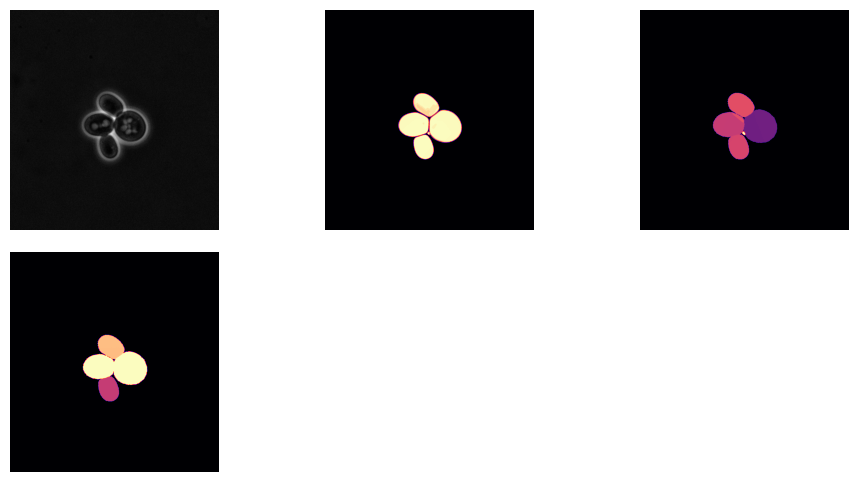

number of detections 26 u_sem 0.55283546 u_mask 0.92905277 u_box 0.030719211 u_det 0.5377778
2    20
0     5
1     1
dtype: int64
3328


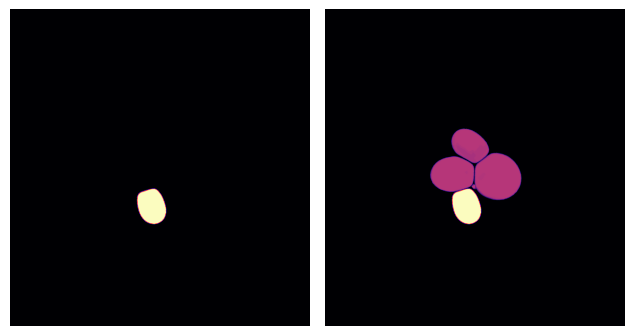

number of detections 32 u_sem 0.5179907 u_mask 0.92800426 u_box 0.29307085 u_det 1.0
1    19
0    11
2     2
dtype: int64
5117


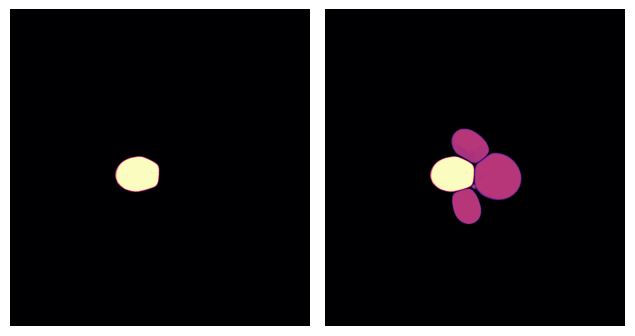

number of detections 29 u_sem 0.58353066 u_mask 0.8491719 u_box 0.27112612 u_det 0.87111104
2    20
0     7
1     2
dtype: int64
4064


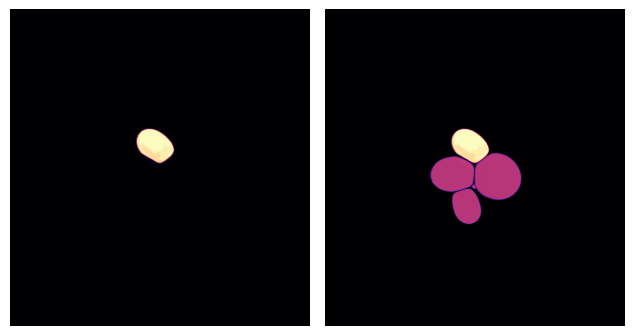

number of detections 44 u_sem 0.31779552 u_mask 0.92130035 u_box 0.3453249 u_det 1.0
1    24
0    15
2     5
dtype: int64
7249


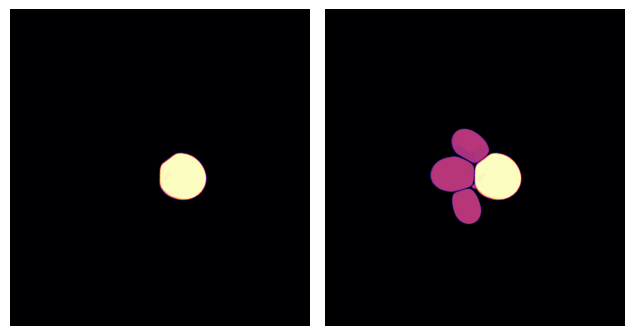

number of detections 2 u_sem 0.9482805 u_mask 0.5223881 u_box 0.7047199 u_det 0
2    2
dtype: int64
67


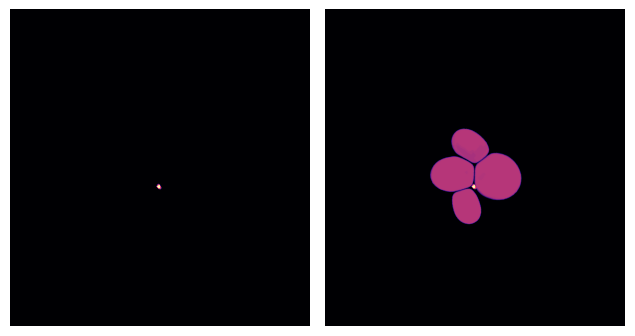

In [95]:
image_id = "acdc_data3_20210722_pos_18_30" 
im_json = get_json_by_id(image_id, test_data)
show_uncertainties(im_json, model, tta_strategy)

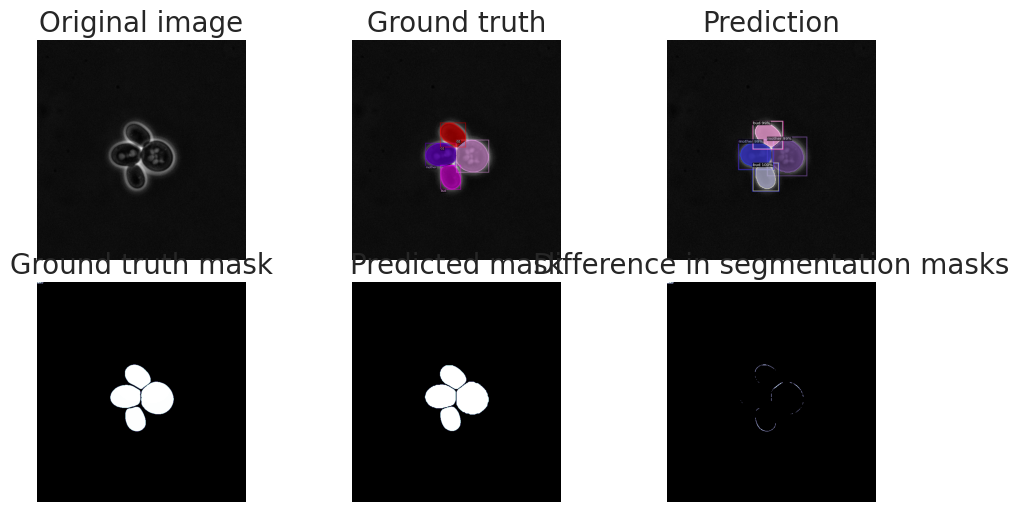

In [96]:
plot_prediction(im_json, "acdc_large_cls_test_slim", cfg, model_path=os.path.join(model_path, "best_model5800.pth"))